# CASO DE ESTUDIO 4 - ELIMINACION DE RUIDO EN IMAGENES

## 1. Configuracion inicial

### 1.1 Instalacion de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import cifar10
from tensorflow.keras.models import Model
import tensorflow as tf

2025-05-07 20:21:48.508567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746642109.202718    5927 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746642109.403144    5927 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746642110.916603    5927 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746642110.916679    5927 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746642110.916680    5927 computation_placer.cc:177] computation placer alr

### 1.2 Carga del dataset CIFAR-10
`keras.datasets.cifar10.load_data()`

In [2]:
# Punto 2.3 aqui incluido

(x_train, _), (x_test, _) = cifar10.load_data()


### 1.3 Exploracion del dataset

- Visualizar 10 ejemplos de imagenes
- Verificar dimensiones

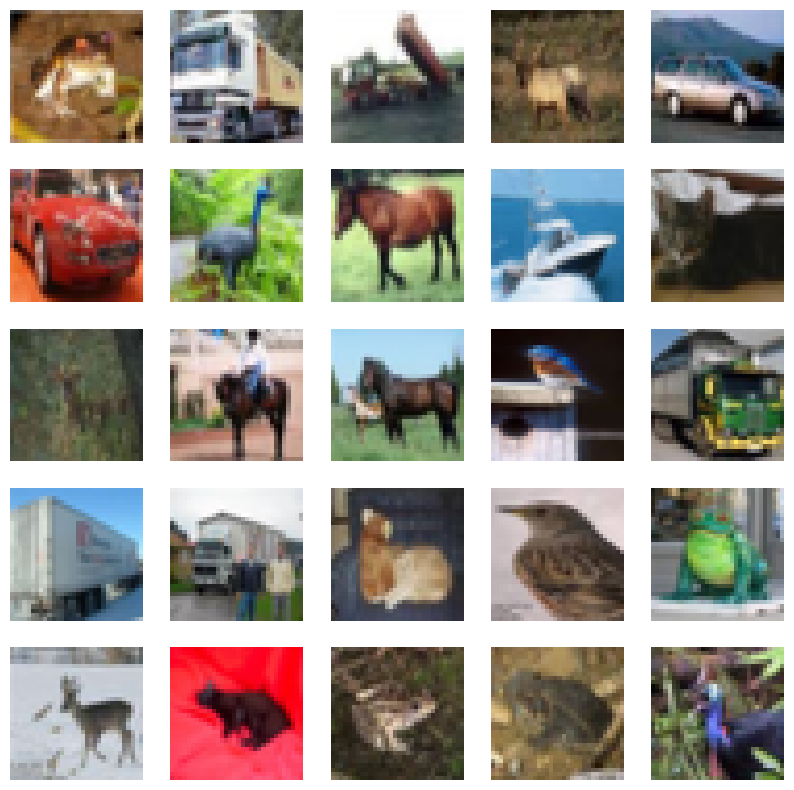

In [3]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')
plt.show()

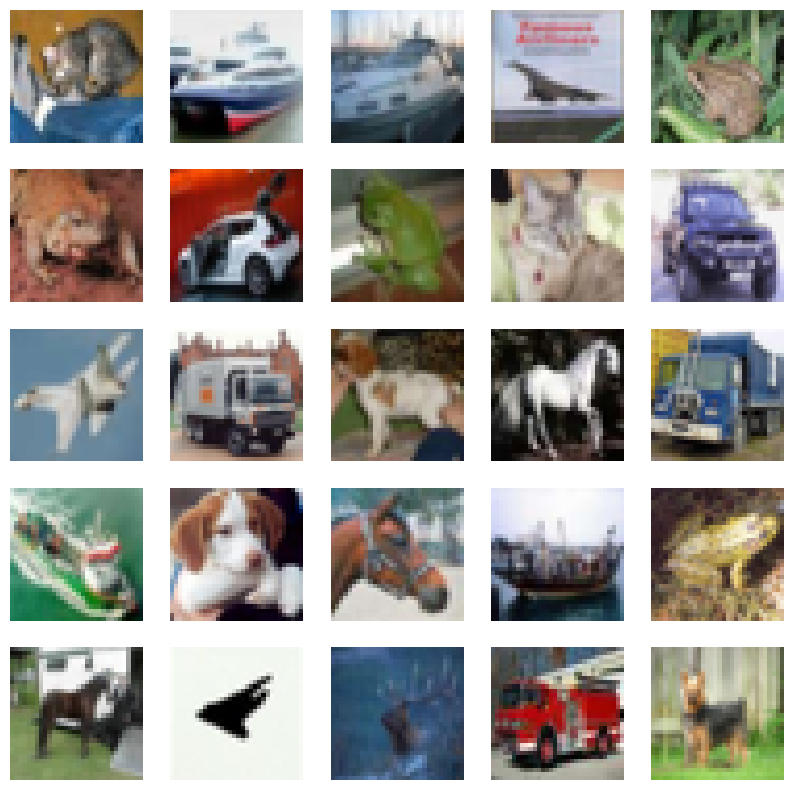

In [4]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.axis('off')
plt.show()

In [5]:
print("Dimensiones de x_train: ", x_train.shape)
print("Dimensiones de x_test: ", x_test.shape)

Dimensiones de x_train:  (50000, 32, 32, 3)
Dimensiones de x_test:  (10000, 32, 32, 3)


## 2. Preparacion de los datos

### 2.1 Normalizar al rango [0, 1]

In [6]:
x_train_normal = x_train.astype('float32') / 255.0
x_test_normal = x_test.astype('float32') / 255.0

### 2.2 Introduccion de ruido
- Introduccion de ruido Gaussiano (media=0, desviacion estandar=0.1) (`np.random.normal`)
- Clip las imagenes a rango [0, 1] (`np.clip(imagen_con_ruido, 0., 1.)`)

In [7]:
x_train_noise = x_train_normal + np.random.normal(loc=0.0 , scale=0.1 , size=x_train_normal.shape)
x_test_noise = x_test_normal + np.random.normal(loc=0.0, scale=0.1, size=x_test_normal.shape)

print(x_train_noise.shape)
print(x_test_noise.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [8]:
x_train_clip = np.clip(x_train_noise, 0., 1.)
x_test_clip = np.clip(x_test_noise, 0., 1.)

print(x_train_clip.shape)
print(x_test_clip.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


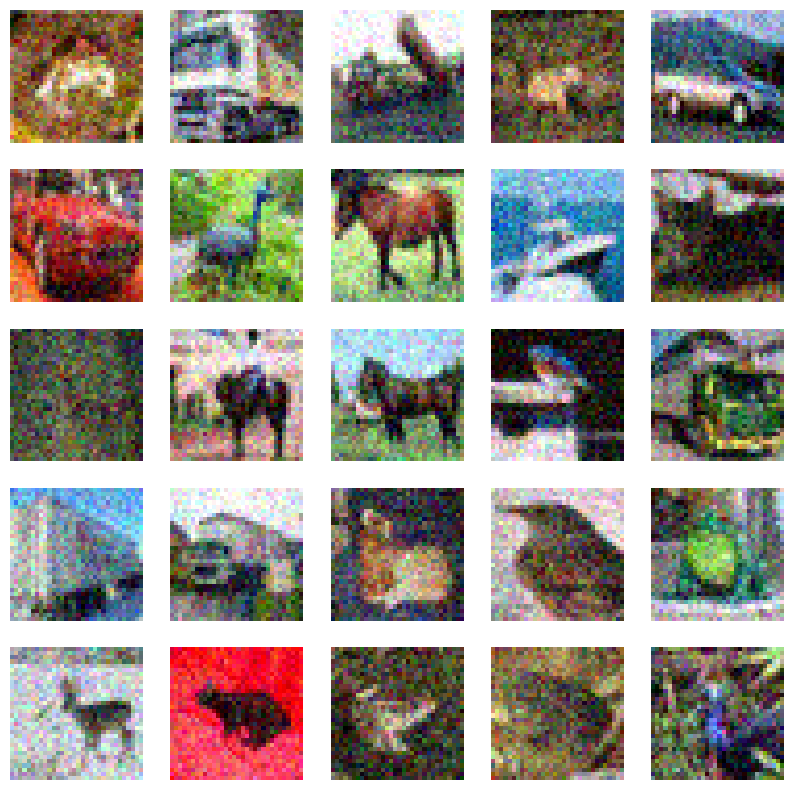

In [9]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train_clip[i], cmap='gray')
    plt.axis('off')
plt.show()

### 2.3 Division de datos
Dividir los datos en entrenamiento (50,000 imágenes) y prueba (10,000 imágenes).

Ya viene pre-dividido por defecto en `keras.datasets.cifar10.load_data()`. No hace falta hacer la separación manual a menos que quieras definir un validation split adicional. Podrías aclarar esto.
```Python
from keras.datasets import cifar10

(x_train, _), (x_test, _) = cifar10.load_data()
```

## 3. Diseño de la Arquitectura
Construir un autoencoder convolucional simetrico

### 3.1 Encoder
- Capas convolucionales (`Conv2D`) con activación ReLU.
- Reducir progresivamente las dimensiones espaciales (ej: 32x32 → 16x16 → 8x8).
- Capa final: "cuello de botella" (espacio latente).

### 3.2 Decoder
- Capas transpuestas (`Conv2DTranspose`) para reconstruir la imagen.
- Usar activación `sigmoid` en la última capa (rango [0, 1]).

In [10]:
# class Denoise(Model):
#   def __init__(self):
#     super(Denoise, self).__init__()
#     self.encoder = tf.keras.Sequential([
#       tf.keras.layers.Input(shape=(32, 32, 3)),
#       tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, activation='relu', padding='same'),
#       tf.keras.layers.Conv2D(16, kernel_size=3, strides=2, activation='relu', padding='same'),
#       tf.keras.layers.Conv2D(8, kernel_size=3, strides=2, activation='relu', padding='same')])

#     self.decoder = tf.keras.Sequential([
#       tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same', output_padding=1),
#       tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
#       tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
#       tf.keras.layers.Conv2D(3, kernel_size=3, activation='sigmoid', padding='same')])


class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),
            tf.keras.layers.Conv2D(64, 3, strides=2, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.1),
            
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.1),
            
            tf.keras.layers.Conv2D(16, 3, strides=2, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.1),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.1),
            
            tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.1),
            
            tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.1),

            tf.keras.layers.Conv2D(3, 3, activation='sigmoid', padding='same')  # Salida en [0, 1]
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Denoise()

I0000 00:00:1746642159.044529    5927 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [11]:
autoencoder.encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 16)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,328 (98.94 KB)

 Trainable params: 25,104 (98.06 KB)

 Non-trainable params: 224 (896.00 B)

In [12]:
autoencoder.decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 4. Entrenamiento del modelo

### 4.1 Compilacion del modelo
- Funcion de perdida: **`MSE`**
- Optimizador: **`Adam`** con **learning rate=0.001**

In [13]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss=tf.keras.losses.MeanSquaredError()
)

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

### 4.2 Entrenar con datos ruidosos como entrada y originales como *target*
- Batch size: 64-128
- Epochs: 20-30

In [14]:
if tf.config.list_physical_devices("GPU"):
    print("Usando GPU :)")
    with tf.device("GPU:0"):
        
        # autoencoder.fit(
        #     x_train_clip[:40000], x_train_normal[:40000],
        #     batch_size=64,
        #     epochs=50,
        #     shuffle=True,
        #     validation_data=(x_test_clip[:8000], x_test_normal[:8000]),
        #     verbose=1
        # )
        autoencoder.fit(
            x_train_clip[:40000], x_train_normal[:40000],
            batch_size=64,
            epochs=50,
            shuffle=True,
            validation_data=(x_test_clip[:8000], x_test_normal[:8000]),
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )
else:
    print("Esto va mal.")

Usando GPU :)


2025-05-07 20:22:42.439669: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 491520000 exceeds 10% of free system memory.
2025-05-07 20:22:43.948690: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 491520000 exceeds 10% of free system memory.
2025-05-07 20:22:44.652135: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 491520000 exceeds 10% of free system memory.
2025-05-07 20:22:44.847860: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 491520000 exceeds 10% of free system memory.


Epoch 1/50


I0000 00:00:1746642168.996541    6218 service.cc:152] XLA service 0x7fa98001a530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746642168.998324    6218 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-05-07 20:22:49.668330: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746642170.892978    6218 cuda_dnn.cc:529] Loaded cuDNN version 90300


 13/625 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0619

I0000 00:00:1746642179.912890    6218 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0235 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0090 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0062 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0057 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0054 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0052 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0050 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0049 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 9/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0048 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 10/50
625/625 

In [15]:
decoded_imgs = autoencoder.predict(x_test_clip)

2025-05-07 20:29:02.723776: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


### 4.3 Guardar el modelo entrenado para evaluacion
- Usar ModelCheckpoint para guardar el mejor modelo durante el entrenamiento.

## 5. Evaluacion y visualizacion

### 5.1 Cuantitativa
Calcular el PSNR (Peak Signal-to-Noise Ratio) entre originales y reconstruidas
- Valores altos de PSNR = mayor calidad
- Se calcula como:
```
psnr = 10 * np.log10(1.0 / (mse + 1e-8))
```

In [16]:
mse = np.mean(np.square(x_test_normal - decoded_imgs), axis=(1, 2, 3))

psnr = 10 * np.log10(1.0 / (mse + 1e-8))

# PSNR promedio
average_psnr = np.mean(psnr)

print(f"PSNR promedio sobre test set: {average_psnr:.2f} dB")

PSNR promedio sobre test set: 24.90 dB


### 5.2 Cualitativa
Visualizar ejemplos de:
- Imagen original
- Imagen ruidosa
- Imagen reconstruida

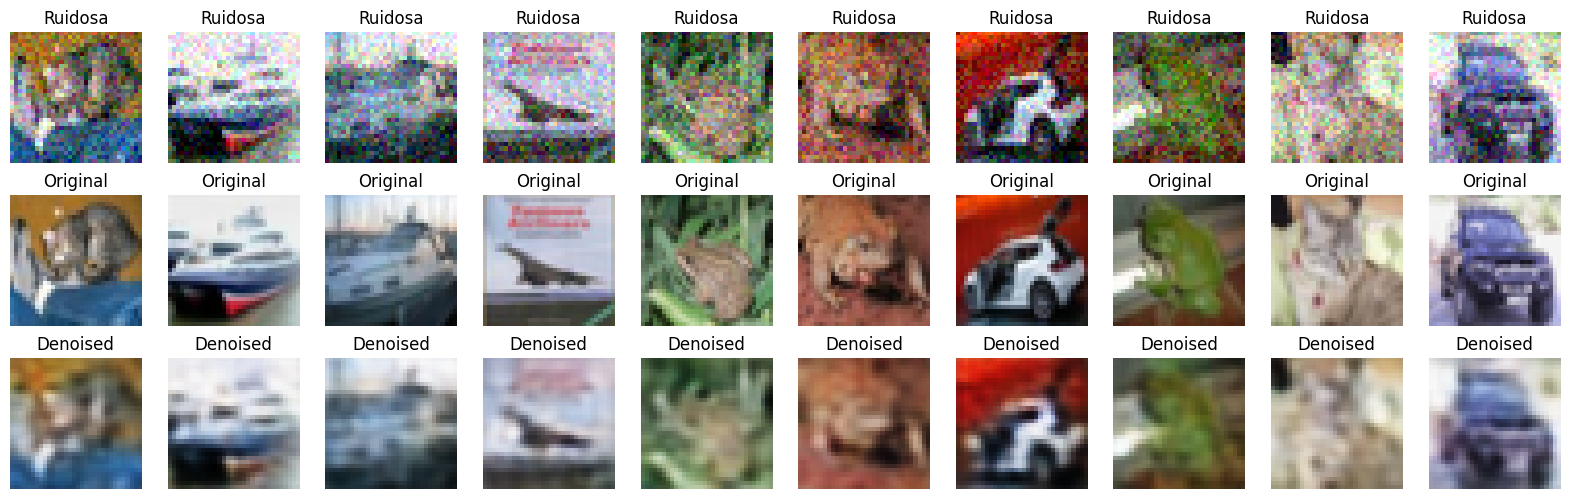

In [17]:
import matplotlib.pyplot as plt

# Visualizar
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    
    # Imagen original
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_normal[i])
    plt.title("Original")
    plt.axis("off")
    
    # Imagen con ruido
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_clip[i])
    plt.title("Ruidosa")
    plt.axis("off")

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("Denoised")
    plt.axis("off")

plt.show()


## 6. Analisis critico
Responder a las siguientes preguntas (entre otras posibles):
- ¿En qué tipos de imágenes (ej: animales, vehículos) funciona mejor el modelo?
- ¿Qué ocurre si aumentamos la intensidad del ruido (ej: desviación estándar=0.2)?
- ¿Cómo afectaría añadir más capas al encoder/decoder?
- Propón una modificación para mejorar el modelo (ej: regularización, dropout).

## 7. Entrega final
Reporte breve (1 página) con:
- Descripción de la arquitectura usada (diagrama opcional).
- Gráficos de pérdida durante entrenamiento.
- PSNR promedio en el dataset de prueba.
- Visualización de 5 ejemplos de reconstrucción.